In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
matches = pd.read_csv('matches.csv', index_col = 0)

In [4]:
def process_data(matches):
  matches['date']=pd.to_datetime(matches['date'])
  matches['venue_code'] = matches['venue'].astype('category').cat.codes
  matches['opp_code'] = matches['opponent'].astype('category').cat.codes
  matches['hour'] = matches['time'].str.replace(':.+','',regex=True).astype('int')
  matches['day_code']= matches['date'].dt.dayofweek
  matches['target']=(matches['result'] == 'W')


In [5]:
process_data(matches)

In [6]:
matches.shape

(1520, 32)

In [7]:
matches.columns

Index(['date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain', 'formation',
       'referee', 'match report', 'notes', 'sh', 'sot', 'dist', 'fk', 'pk',
       'pkatt', 'season', 'team', 'venue_code', 'opp_code', 'hour', 'day_code',
       'target'],
      dtype='object')

In [8]:
test = matches[matches['date'] > '2022-01-01']
train = matches[matches['date'] < '2022-01-01']

In [9]:
predictors = ['venue_code', 'opp_code', 'hour', 'day_code']

In [10]:
# Initial Test of kernels
def evaluate_svm_kernels(train, test, predictors, poly_degrees=None):
    """
    Evaluates SVM models with different kernels and degrees for the polynomial kernel,
    returning the accuracy, precision, recall, and F1 scores.

    Parameters:
    - train_data: Training dataset
    - test_data: Test dataset
    - predictors: List of column names to use as predictors
    - poly_degrees: List of degrees to evaluate with the polynomial kernel

    Returns:
    A dictionary where keys are kernel names (or 'poly_degree_x' for polynomial kernels)
    and values are dictionaries with 'accuracy', 'precision', 'recall', and 'f1_score' scores.
    """

    results = {}

    if poly_degrees is None:
        poly_degrees = [1, 3, 5, 6, 8]  # Default degrees for polynomial kernel if not specified

    kernels = ['linear', 'rbf', 'poly', 'sigmoid']

    class_weights = 'balanced'  # Balanced class weights to handle class imbalance

    for kernel in kernels:
        if kernel == 'poly':
            for degree in poly_degrees:
                svm_model = SVC(kernel=kernel, degree=degree, class_weight=class_weights)
                svm_model.fit(train[predictors], train['target'])

                predictions = svm_model.predict(test[predictors])

                accuracy = accuracy_score(test['target'], predictions)
                precision = precision_score(test['target'], predictions, zero_division=0)
                recall = recall_score(test['target'], predictions)
                f1 = f1_score(test['target'], predictions)

                results[f'poly_degree_{degree}'] = {'accuracy': accuracy*100, 'precision': precision*100,
                                                     'recall': recall*100, 'f1_score': f1*100}
        else:
            svm_model = SVC(kernel=kernel, class_weight=class_weights)
            svm_model.fit(train[predictors], train['target'])

            predictions = svm_model.predict(test[predictors])

            accuracy = accuracy_score(test['target'], predictions)
            precision = precision_score(test['target'], predictions, zero_division=0)
            recall = recall_score(test['target'], predictions)
            f1 = f1_score(test['target'], predictions)

            results[kernel] = {'accuracy': accuracy*100, 'precision': precision*100,
                               'recall': recall*100, 'f1_score': f1*100}

    return results

In [11]:
kernel_evaluation = evaluate_svm_kernels(train, test, predictors)

In [12]:
kernel_evaluation

{'linear': {'accuracy': 58.01393728222997,
  'precision': 47.038327526132406,
  'recall': 60.26785714285714,
  'f1_score': 52.83757338551859},
 'rbf': {'accuracy': 58.88501742160279,
  'precision': 46.36363636363636,
  'recall': 34.151785714285715,
  'f1_score': 39.33161953727507},
 'poly_degree_1': {'accuracy': 53.9198606271777,
  'precision': 42.01183431952663,
  'recall': 47.544642857142854,
  'f1_score': 44.60732984293194},
 'poly_degree_3': {'accuracy': 60.62717770034843,
  'precision': 49.26470588235294,
  'recall': 29.910714285714285,
  'f1_score': 37.22222222222223},
 'poly_degree_5': {'accuracy': 58.62369337979094,
  'precision': 46.633416458852864,
  'recall': 41.74107142857143,
  'f1_score': 44.05182567726737},
 'poly_degree_6': {'accuracy': 57.40418118466899,
  'precision': 45.5531453362256,
  'recall': 46.875,
  'f1_score': 46.20462046204621},
 'poly_degree_8': {'accuracy': 58.536585365853654,
  'precision': 46.236559139784944,
  'recall': 38.392857142857146,
  'f1_score':

In [13]:
# HYPER PARAMETER TUNING with less Data
# Set random seed

def random_search(data, predictors, random_seed=42):
    train = data[data["date"] < '2022-01-01']

    param_grid = {
        'C': [0.1, 1, 100, 1000],
        'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
        'degree': [1, 2, 3, 4, 5, 6],
    }

    random_search = RandomizedSearchCV(estimator=SVC(), param_distributions=param_grid, n_iter=5, random_state=random_seed, cv=5)
    random_search.fit(train[predictors], train['target'])

    return random_search.cv_results_

In [14]:
random_search_results = random_search(matches, predictors)

In [15]:
random_search_cv_results_df = pd.DataFrame(random_search_results)

In [16]:
random_search_cv_results_df[['param_C', 'param_kernel', 'mean_test_score']]

,param_C,param_kernel,mean_test_score
0,1000,rbf,0.628545
1,1000,poly,0.633876
2,1000,poly,0.633876
3,1000,sigmoid,0.508071
4,1,poly,0.633876


In [17]:
def top_n_kernels(cv_results, N=5):
    # Convert the cv_results (if not already a DataFrame) to a DataFrame
    if not isinstance(cv_results, pd.DataFrame):
        results_df = pd.DataFrame(cv_results)
    else:
        results_df = cv_results

    # Set 'degree' to 1 for all non-'poly' kernels
    results_df.loc[results_df['params'].apply(lambda x: x['kernel'] != 'poly'), 'params'] = \
        results_df['params'].apply(lambda x: {**x, 'degree': 1})

    # Sort by mean_test_score and remove duplicates based on 'params'
    sorted_results_df = results_df.sort_values(by='mean_test_score', ascending=False).drop_duplicates(subset='params')

    top_params = sorted_results_df.head(N)[['params', 'mean_test_score']].to_dict('records')

    return top_params


In [18]:
# using the results from random search hyperparameter tuning to get the top kernels
top_kernels = top_n_kernels(random_search_cv_results_df)

In [19]:
top_kernels

[{'params': {'kernel': 'poly', 'degree': 2, 'C': 1000},
  'mean_test_score': 0.63387634209552},
 {'params': {'kernel': 'poly', 'degree': 1, 'C': 1000},
  'mean_test_score': 0.63387634209552},
 {'params': {'kernel': 'poly', 'degree': 3, 'C': 1},
  'mean_test_score': 0.63387634209552},
 {'params': {'kernel': 'rbf', 'degree': 1, 'C': 1000},
  'mean_test_score': 0.6285449833395038},
 {'params': {'kernel': 'sigmoid', 'degree': 1, 'C': 1000},
  'mean_test_score': 0.5080710847834136}]

In [20]:
# Evaluate the top kernels and their corresponding hyperparameters
def evaluate_top_kernels(train, test, predictors, top_params):
    results = {}

    for param_set in top_params:
        kernel = param_set['params']['kernel']
        C = param_set['params'].get('C', 1)  # Default to 1 if C is not specified
        degree = param_set['params'].get('degree', 3)  # Default to 3 if degree is not specified

        svm_model = SVC(kernel=kernel, C=C, degree=degree, class_weight= 'balanced')
        svm_model.fit(train[predictors], train['target'])

        predictions = svm_model.predict(test[predictors])

        accuracy = accuracy_score(test['target'], predictions)
        precision = precision_score(test['target'], predictions, zero_division=0)
        recall = recall_score(test['target'], predictions, zero_division=0)
        f1 = f1_score(test['target'], predictions, zero_division=0)

        if kernel == 'poly':
            kernel_name = f'poly_degree_{degree}'
        else:
            kernel_name = kernel

        results[kernel_name] = {
            'accuracy': f'{accuracy * 100:.2f}%',
            'precision': f'{precision * 100:.2f}%',
            'recall': f'{recall * 100:.2f}%',
            'F1': f'{f1 * 100:.2f}%'
        }

    return results

In [21]:
kernel_evaluations_without_rolling_averages = evaluate_top_kernels(train, test, predictors, top_kernels)

In [22]:
kernel_evaluations_without_rolling_averages

{'poly_degree_2': {'accuracy': '56.53%',
  'precision': '46.09%',
  'recall': '67.19%',
  'F1': '54.68%'},
 'poly_degree_1': {'accuracy': '58.01%',
  'precision': '47.04%',
  'recall': '60.27%',
  'F1': '52.84%'},
 'poly_degree_3': {'accuracy': '60.63%',
  'precision': '49.26%',
  'recall': '29.91%',
  'F1': '37.22%'},
 'rbf': {'accuracy': '58.97%',
  'precision': '47.16%',
  'recall': '42.63%',
  'F1': '44.78%'},
 'sigmoid': {'accuracy': '49.22%',
  'precision': '38.05%',
  'recall': '47.99%',
  'F1': '42.45%'}}

## Next we try to get better results by using a larger dataset and rolling averages

In [23]:
# We try to get better results by using a larger dataset and rolling averages
# Get the full dataset and evaluate kernels on the data
matches = pd.read_csv('matches_6_years.csv', index_col = 0)
process_data(matches)

In [24]:
matches.shape

(4560, 32)

In [25]:
process_data(matches)

In [26]:
grouped_matches = matches.groupby('team')
group= grouped_matches.get_group('Manchester City')

In [27]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(3, closed ='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

In [28]:
cols = ["gf", "ga", "sh", "sot", "dist", "fk", "pk", "pkatt"]
new_cols = [f"{c}_rolling" for c in cols]

In [29]:
matches_rolling = matches.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols))


In [30]:
matches_rolling = matches_rolling.droplevel("team")
matches_rolling.index = range(matches_rolling.shape[0])

In [31]:
matches_rolling.index = range(matches_rolling.shape[0])

In [32]:
# Evaluating with new predictors ,expanded data set, and using top ten params
rolling_train = matches_rolling[matches_rolling["date"]< '2022-01-01']
rolling_test = matches_rolling[matches_rolling["date"]>'2022-01-01']
rolling_predictors = predictors + new_cols
kernel_evaluations_with_rolling_averages = evaluate_top_kernels(rolling_train, rolling_test, rolling_predictors, top_kernels)

In [33]:
kernel_evaluations_with_rolling_averages

{'poly_degree_2': {'accuracy': '64.19%',
  'precision': '54.23%',
  'recall': '53.02%',
  'F1': '53.62%'},
 'poly_degree_1': {'accuracy': '62.79%',
  'precision': '52.02%',
  'recall': '60.40%',
  'F1': '55.90%'},
 'poly_degree_3': {'accuracy': '64.19%',
  'precision': '54.50%',
  'recall': '50.11%',
  'F1': '52.21%'},
 'rbf': {'accuracy': '62.27%',
  'precision': '51.63%',
  'recall': '53.24%',
  'F1': '52.42%'},
 'sigmoid': {'accuracy': '44.72%',
  'precision': '36.44%',
  'recall': '55.93%',
  'F1': '44.13%'}}

In [34]:
## Compared with original evaluations without rolling averages
kernel_evaluations_without_rolling_averages

{'poly_degree_2': {'accuracy': '56.53%',
  'precision': '46.09%',
  'recall': '67.19%',
  'F1': '54.68%'},
 'poly_degree_1': {'accuracy': '58.01%',
  'precision': '47.04%',
  'recall': '60.27%',
  'F1': '52.84%'},
 'poly_degree_3': {'accuracy': '60.63%',
  'precision': '49.26%',
  'recall': '29.91%',
  'F1': '37.22%'},
 'rbf': {'accuracy': '58.97%',
  'precision': '47.16%',
  'recall': '42.63%',
  'F1': '44.78%'},
 'sigmoid': {'accuracy': '49.22%',
  'precision': '38.05%',
  'recall': '47.99%',
  'F1': '42.45%'}}

In [35]:
# Convert the dictionaries to DataFrames
df_with_rolling = pd.DataFrame(kernel_evaluations_with_rolling_averages).T
df_without_rolling = pd.DataFrame(kernel_evaluations_without_rolling_averages).T

# Extract all columns
all_cols_with_rolling = df_with_rolling[['accuracy', 'precision', 'recall', 'F1']]
all_cols_without_rolling = df_without_rolling[['accuracy', 'precision', 'recall', 'F1']]

# Combine the columns side by side
combined_df = pd.concat([all_cols_with_rolling, all_cols_without_rolling],
                         axis=1, keys=['With Rolling', 'Without Rolling'])

# Display the combined DataFrame
combined_df

With Rolling                           Without Rolling  \
                  accuracy precision  recall      F1        accuracy   
poly_degree_2       64.19%    54.23%  53.02%  53.62%          56.53%   
poly_degree_1       62.79%    52.02%  60.40%  55.90%          58.01%   
poly_degree_3       64.19%    54.50%  50.11%  52.21%          60.63%   
rbf                 62.27%    51.63%  53.24%  52.42%          58.97%   
sigmoid             44.72%    36.44%  55.93%  44.13%          49.22%   

                                         
              precision  recall      F1  
poly_degree_2    46.09%  67.19%  54.68%  
poly_degree_1    47.04%  60.27%  52.84%  
poly_degree_3    49.26%  29.91%  37.22%  
rbf              47.16%  42.63%  44.78%  
sigmoid          38.05%  47.99%  42.45%

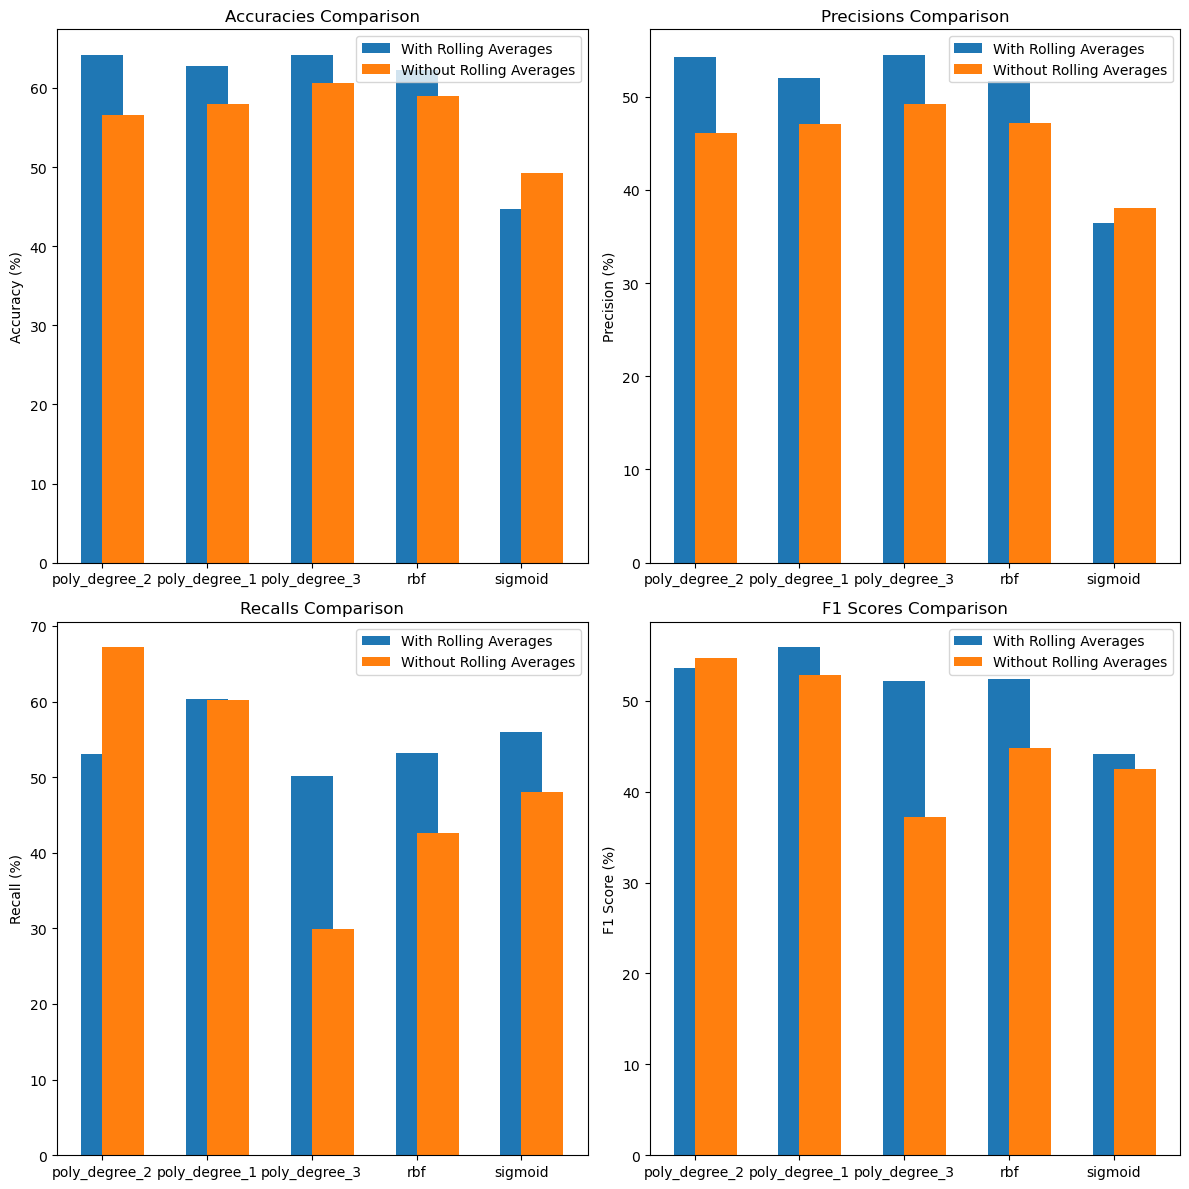

In [36]:
# Extract accuracy, precision, recall, and F1 score values
accuracies_with_rolling = df_with_rolling['accuracy'].str.rstrip('%').astype(float)
accuracies_without_rolling = df_without_rolling['accuracy'].str.rstrip('%').astype(float)
precisions_with_rolling = df_with_rolling['precision'].str.rstrip('%').astype(float)
precisions_without_rolling = df_without_rolling['precision'].str.rstrip('%').astype(float)
recalls_with_rolling = df_with_rolling['recall'].str.rstrip('%').astype(float)
recalls_without_rolling = df_without_rolling['recall'].str.rstrip('%').astype(float)
f1scores_with_rolling = df_with_rolling['F1'].str.rstrip('%').astype(float)
f1scores_without_rolling = df_without_rolling['F1'].str.rstrip('%').astype(float)

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# Accuracies comparison
axes[0, 0].bar(df_with_rolling.index, accuracies_with_rolling, width=0.4, label='With Rolling Averages', align='center')
axes[0, 0].bar(df_without_rolling.index, accuracies_without_rolling, width=0.4, label='Without Rolling Averages', align='edge')
axes[0, 0].set_title('Accuracies Comparison')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].legend()

# Precisions comparison
axes[0, 1].bar(df_with_rolling.index, precisions_with_rolling, width=0.4, label='With Rolling Averages', align='center')
axes[0, 1].bar(df_without_rolling.index, precisions_without_rolling, width=0.4, label='Without Rolling Averages', align='edge')
axes[0, 1].set_title('Precisions Comparison')
axes[0, 1].set_ylabel('Precision (%)')
axes[0, 1].legend()

# Recalls comparison
axes[1, 0].bar(df_with_rolling.index, recalls_with_rolling, width=0.4, label='With Rolling Averages', align='center')
axes[1, 0].bar(df_without_rolling.index, recalls_without_rolling, width=0.4, label='Without Rolling Averages', align='edge')
axes[1, 0].set_title('Recalls Comparison')
axes[1, 0].set_ylabel('Recall (%)')
axes[1, 0].legend()

# F1 scores comparison
axes[1, 1].bar(df_with_rolling.index, f1scores_with_rolling, width=0.4, label='With Rolling Averages', align='center')
axes[1, 1].bar(df_without_rolling.index, f1scores_without_rolling, width=0.4, label='Without Rolling Averages', align='edge')
axes[1, 1].set_title('F1 Scores Comparison')
axes[1, 1].set_ylabel('F1 Score (%)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()